# Load Shedding and Shifting Example

This example is a simple illustration that aims to explain the use of load shedding and load shifting in PyPSA. The example is designed to simulate a single day of electrical consumption in a small network with solar generation, which could represent a single house or a small group of houses.

In [7]:
import pypsa
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd

### Create network

In [8]:
network = pypsa.Network()

### Build the snapshots we consider for the first T hours in 2023


In [9]:
network.set_snapshots(pd.date_range("2023-01-01 04:00", "2023-01-01 20:00", freq="H"))

print(network.snapshots)

DatetimeIndex(['2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               '2023-01-01 10:00:00', '2023-01-01 11:00:00',
               '2023-01-01 12:00:00', '2023-01-01 13:00:00',
               '2023-01-01 14:00:00', '2023-01-01 15:00:00',
               '2023-01-01 16:00:00', '2023-01-01 17:00:00',
               '2023-01-01 18:00:00', '2023-01-01 19:00:00',
               '2023-01-01 20:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq='H')


### Add fuel types

In [10]:
network.add("Carrier", "solar")
network.add("Carrier", "load")
network.add("Carrier", "battery")

### Add buses

In [11]:
network.add("Bus", "My bus")

### Add generators

Solar PV panel generation per unit of capacity is considered only in the daytime.

"load shedding" is introduced as a generator to illustrate the decrease in demand, thereby enhancing the generation. It is essential when the network's generation is insufficient to fulfill the required demand

In [12]:
# Add solar generation
pv_pu = [
    0.0,
    0.0,
    0.0,
    0.2,
    0.4,
    0.65,
    0.85,
    0.9,
    0.85,
    0.65,
    0.4,
    0.3,
    0.2,
    0.1,
    0.0,
    0.0,
    0.0,
]
network.add(
    "Generator",
    "solar",
    bus="My bus",
    p_nom=0.4,
    carrier="solar",
    p_max_pu=pv_pu,
    marginal_cost=0 + 0.01 * np.random.random(),
)

# Add load shedding as generator
network.add(
    "Generator",
    "load shedding",
    bus="My bus",
    p_nom=50,
    carrier="load",
    p_max_pu=1.0,
    marginal_cost=1e2,
    p_nom_extendable=True,
)

### Add constant base load values

In [13]:
load = pd.Series(0.2, index=range(17))  # constant baseload
network.add("Load", "baseload", bus="My bus", p_set=load.values)

### Add storage units to the network

Storage units could be used to represent load shifting in PyPSA, where energy use is in peak hours is shifted to off-peak hours, which is a similar behaviour to discharging a storage unit in peak hours and charging it in off-peak hours.

Smart thermostats can shift the timing of energy use by automatically reducing heating or cooling during peak demand periods and increasing it during off-peak periods.

In [14]:
network.add(
    "StorageUnit",
    "smart thermostat",
    bus="My bus",
    p_nom=0,
    carrier="battery",
    marginal_cost=4 * np.random.random(),
    p_nom_extendable=True,
    p_max_pu=1,
    p_min_pu=-1,
    efficiency_store=0.9,
    efficiency_dispatch=0.95,
    standing_loss=0.01,
    cyclic_state_of_charge=True,
    max_hours=6,
)

### Optimize the network and plot some results

In [15]:
network.lopf()

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+02


('ok', 'optimal')

Text(0, 0.5, 'Power (MW)')

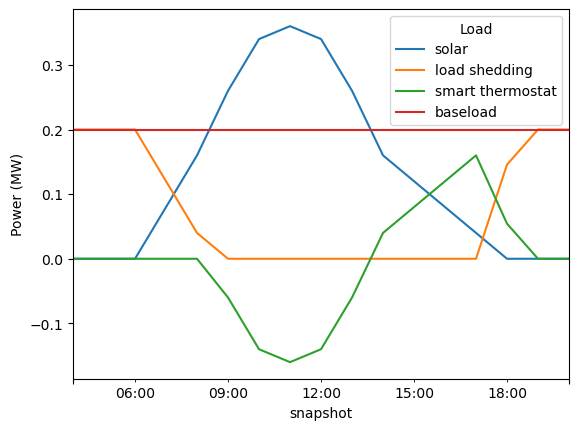

In [16]:
fig, ax = plt.subplots()

network.generators_t.p.plot(ax=ax)
network.storage_units_t.p.plot(ax=ax)
network.loads_t.p.plot(ax=ax)

ax.set_ylabel("Power (MW)")

We can observe from the least cost solution the following:
- The smart thermostat is increasing the demand during the peak solar generation, to save energy when there is a lack of supply
- In the first and last hours of the day, load shedding is applied since there is not enough storage or generation available